In [1]:
%matplotlib inline
from astropy.table import Table
from tqdm.notebook import tqdm
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

In [2]:
sys.path.append('/home/aalvarez/Work/Projects/Elements/5.8/InstallArea/x86_64-fc31-gcc92-dbg/python/')
sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/python/')
os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/auxdir/'
os.environ['PATH'] = os.environ['PATH'] + ':/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/build.x86_64-fc31-gcc92-dbg/scripts/'

In [3]:
from nnpz.photometry import *
from nnpz.reference_sample.ReferenceSample import ReferenceSample
from nnpz.program import BuildPhotometry

In [4]:
reference = ReferenceSample('/home/aalvarez/Work/Data/WillHartley/ReferenceSample/')

In [5]:
ref_catalog = Table.read('/home/aalvarez/Work/Data/WillHartley/NNPZ_filter_shift_reference_24Feb20.fits')

In [6]:
class SedProvider(object):
    def __init__(self, basedir):
        self.__basedir = basedir
        self.__cache = dict()
        
    def get_sed(self, name):
        if name not in self.__cache:
            self.__cache[name] = np.genfromtxt(os.path.join(self.__basedir, name))
        return self.__cache[name]

In [7]:
def redshift_sed(sed, z):
    sed = np.copy(sed)
    sed[:, 0] *= (1 + z)
    sed[:, 1] /= (1 + z)**2
    return sed

In [8]:
filter_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/WillHartley/DC3')
sed_provider = SedProvider('/home/aalvarez/Phosphoros/AuxiliaryData/SEDs/')

In [9]:
transmissions = dict()
trans_range = [1e50, -1e50]
for filter_name in ['u', 'vis']:#, 'Y', 'J']:
    print(f'Loading {filter_name}')
    transmissions[filter_name] = filter_provider.getFilterTransmission(filter_name)
    trans_range[0] = np.min([trans_range[0], np.min(transmissions[filter_name][:,0])])
    trans_range[1] = np.max([trans_range[1], np.max(transmissions[filter_name][:,0])])

Loading u
Loading vis


In [10]:
items = list(transmissions.items())
for filter_name, transmission in items:
    for shift in [-50, -20, 0, 20, 50, 100]:
        shifted = np.copy(transmission)
        shifted[:,0] += shift
        transmissions[f'{filter_name} + {shift}'] = shifted

In [27]:
def plot_sed_and_filters(ax, sed, rawsed):
    for f, t in transmissions.items():
        interp_grid = np.sort(np.concatenate([sed[:, 0], t[:, 0]]))
        interp_sed = np.interp(interp_grid, sed[:,0], sed[:,1])
        interp_filter = np.interp(interp_grid, t[:,0], t[:,1])
        
        compos = interp_sed*interp_filter
        integral = np.trapz(compos, x=interp_grid)
        integral2 = np.trapz(interp_sed*interp_filter*interp_grid, x=interp_grid)
        range_filter = compos > 0
        ax.plot(interp_grid[range_filter], (interp_filter)[range_filter], label=f'{f} ({integral:.3e} / {integral2:.3e})')
        
    range_filter = np.logical_and(sed[:,0] >= trans_range[0], sed[:,0] <= trans_range[1])

    sed = sed[range_filter,:].copy()
    sed[:,1] *= sed[:,0]
    sed[:,1] /= np.max(sed[:,1]) / 0.7
    #ax.plot(sed[:,0], sed[:,1], label='SED*Wavelength', linestyle='--')
    
    rawsed = rawsed[range_filter,:].copy()
    rawsed[:,1] /= np.max(rawsed[:,1]) / 0.7
    ax.plot(rawsed[:,0], rawsed[:,1], label='SED', linestyle=':')
    
    ax.legend()

# Plot one reference object vs shifted filters

In [28]:
def plot_shifted(ref_id):
    sed = reference.getSedData(ref_id)
    pdz = reference.getPdzData(ref_id)
    z = pdz[np.argmax(pdz[:,1]),0]
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    
    ref_obj = ref_catalog[ref_catalog['ID'] == ref_id][0]
    sed_name = ref_obj['SED_name']
    rawsed = sed_provider.get_sed(sed_name)
    rawsed = redshift_sed(rawsed, ref_obj['z'])
    plot_sed_and_filters(ax, sed, rawsed)
    plt.suptitle(f'#{ref_id} ({sed_name} {z:.2}z)')
    plt.show()

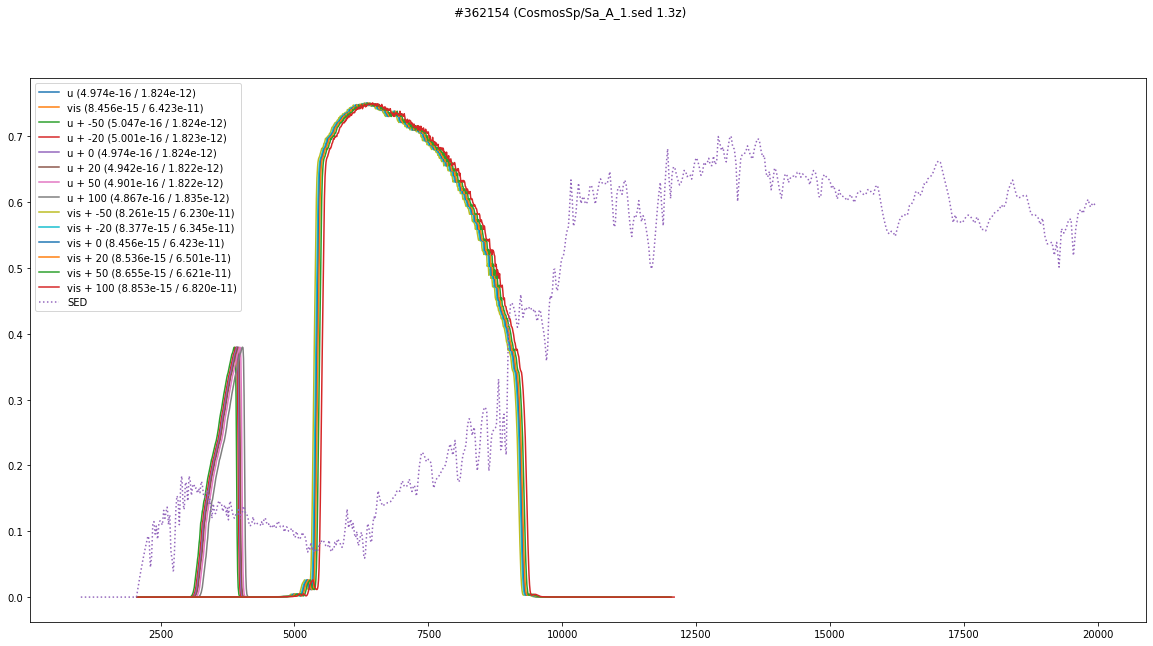

In [29]:
plot_shifted(362154)

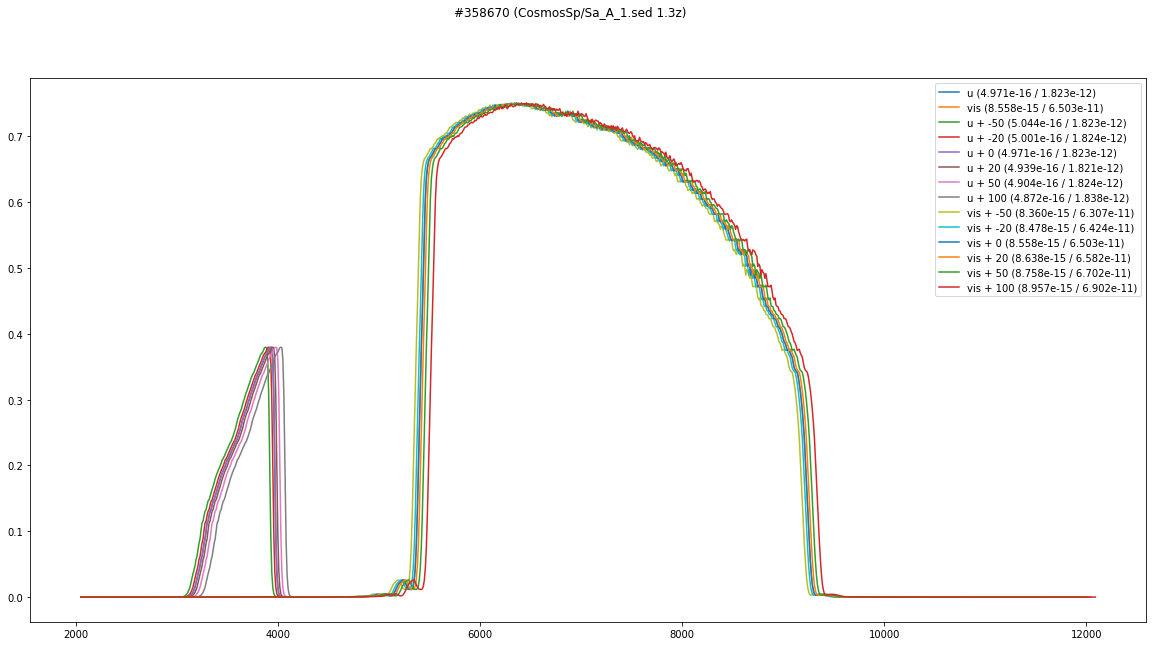

In [14]:
plot_shifted(358670)

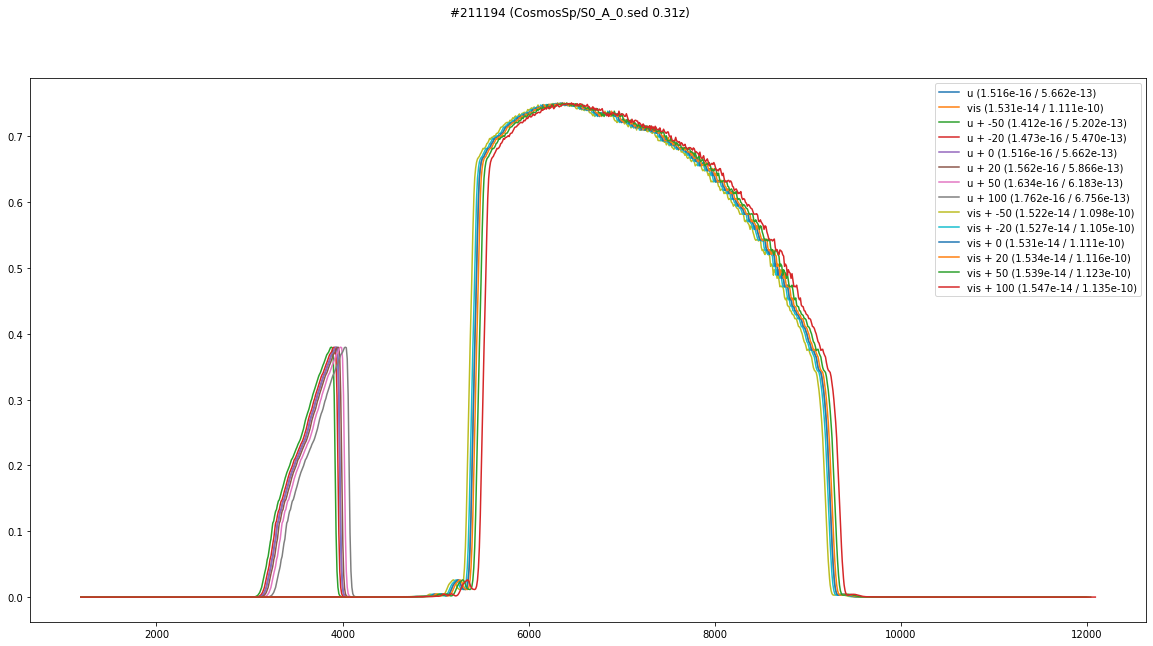

In [15]:
plot_shifted(211194)

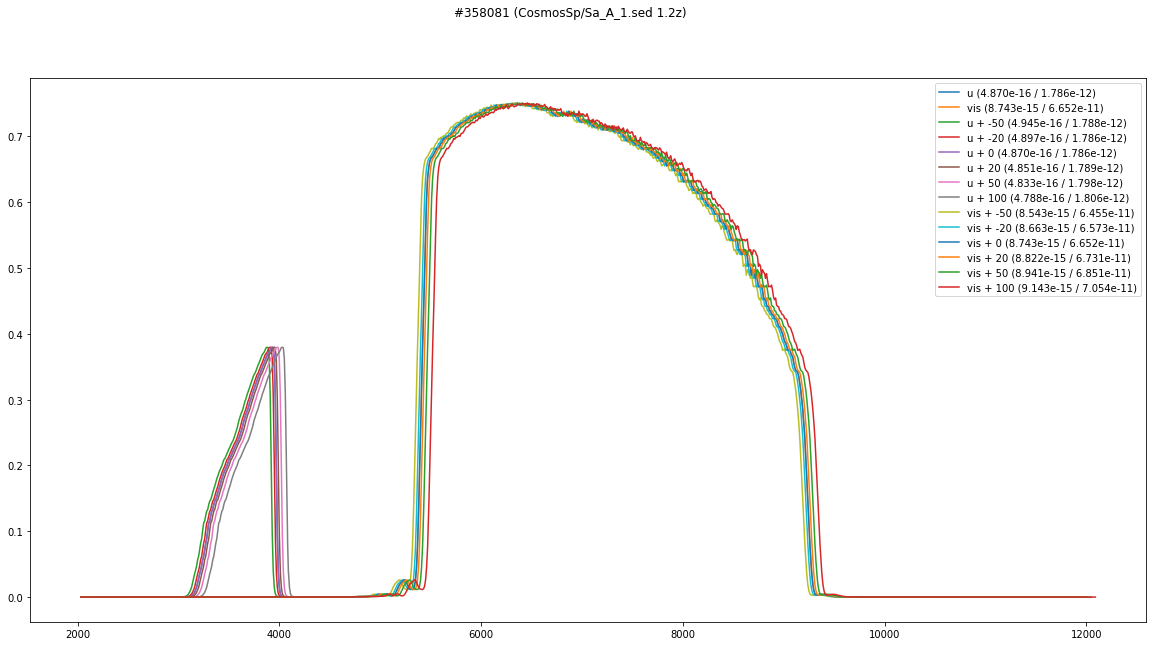

In [16]:
plot_shifted(358081)

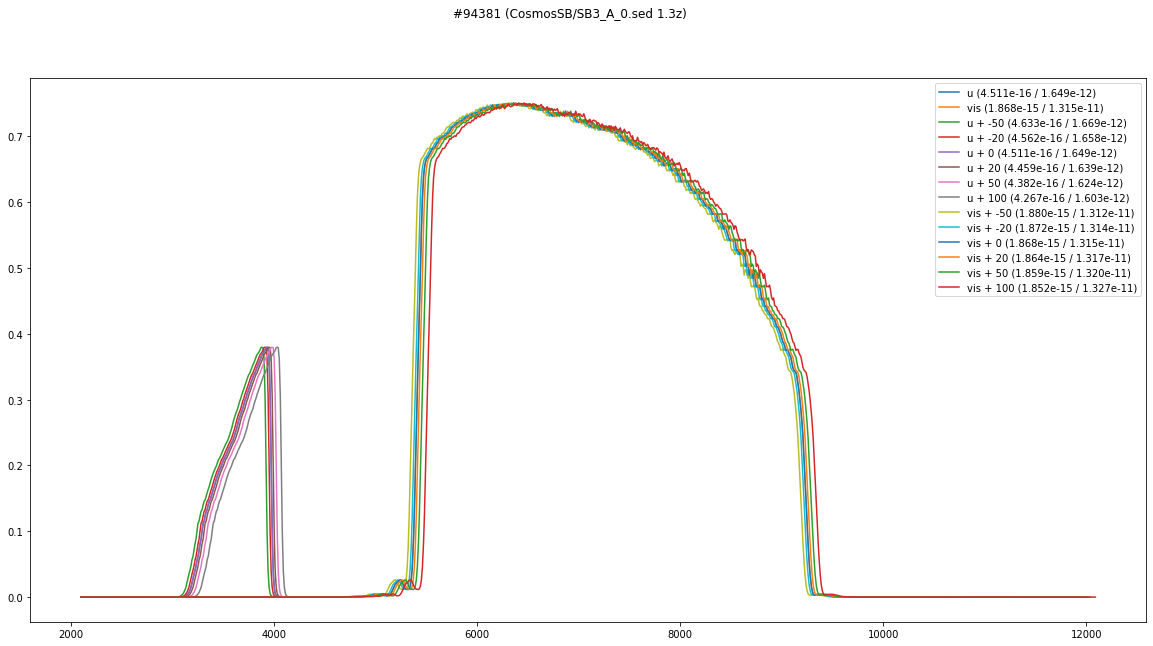

In [17]:
plot_shifted(94381)